In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

from PIL import Image
import glob

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate 

In [2]:


#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))



In [3]:
train_dir = 'data/chest_xray/train'
valid_dir = 'data/chest_xray/validation'
test_dir = 'data/chest_xray/test'

In [4]:
img_width, img_height = 75, 75
batch_size = 16
num_epochs = 1
filter_size = (3, 3)
pool_size = (2, 2)
drop_out_dense = 0.5
drop_out_conv = 0.25
padding = 'same'
#learning_rate = 0.02
#decay = learning_rate / (num_epochs - 1)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 5216 images belonging to 2 classes.


In [6]:
validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


Found 624 images belonging to 2 classes.


In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=filter_size, activation='relu', input_shape=(img_width, img_height, 1), padding=padding))
model.add(Conv2D(32, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [9]:
SGD = keras.optimizers.SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            #class_weight= {0:.40, 1:.60},
            validation_data = validation_generator)

Epoch 1/1
326/326 [==============================] - 151s 464ms/step - loss: 0.5828 - acc: 0.7433 - val_loss: 0.7872 - val_acc: 0.5000


In [10]:
score = model.evaluate_generator(test_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.6815625840425491
Test Accuracy:  0.6225


In [11]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [12]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

1/1 [==============================] - 0s 385ms/step
No of errors = 8/16


In [ ]:
import cv2
from random import randint


test_image = cv2.imread('data/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

In [ ]:
print(plt.imshow(test_image))

In [ ]:
# test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = cv2.resize(test_image, (img_height, img_width))
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255

In [ ]:
print(test_image.shape)

In [ ]:
print(plt.imshow(test_image))

In [ ]:
test_image = np.expand_dims(test_image, axis=3)
test_image = np.expand_dims(test_image, axis=0)
print (test_image.shape)

In [ ]:
print((model.predict(test_image)))

In [ ]:
print(model.predict_classes(test_image))

In [32]:
weights = model.get_weights()[0]
layer_weight=[]
for weight in weights:
    layer_weight.append(weight)

In [33]:
weights

array([[[[ 0.07501085,  0.06529691, -0.06626766,  0.0378916 ,
           0.04472608,  0.10504219,  0.0585599 ,  0.14275585,
           0.14296044,  0.13622016,  0.01352376,  0.06977373,
          -0.08111636,  0.13069749,  0.06765175,  0.03068298,
          -0.14023787, -0.12862077,  0.01417797,  0.01318771,
          -0.10611198,  0.08634435, -0.11377233, -0.14133646,
          -0.0530465 ,  0.114983  , -0.00073535,  0.0571212 ,
          -0.1153435 , -0.07348096, -0.05622436, -0.08317913]],

        [[-0.04436992, -0.04884908, -0.13227817, -0.02455668,
          -0.02540145,  0.11012945,  0.04606213, -0.13209406,
           0.07763628, -0.11228511, -0.0736466 , -0.09169076,
          -0.08205926, -0.13088427, -0.06539575, -0.13184099,
           0.02041699, -0.05654549,  0.03751272, -0.12383703,
          -0.01655298,  0.05094901, -0.10240412,  0.11740635,
          -0.0442507 ,  0.03436581, -0.07357156, -0.01802601,
           0.09440172, -0.11557369,  0.06093106, -0.04507881]],

  

In [34]:
# weight_conv2d_1 = history.model.layers[0].get_weights()[0][:,:,0,:]

weight_conv2d_2 = model.layers[4].get_weights()[0][:,:,3,:]

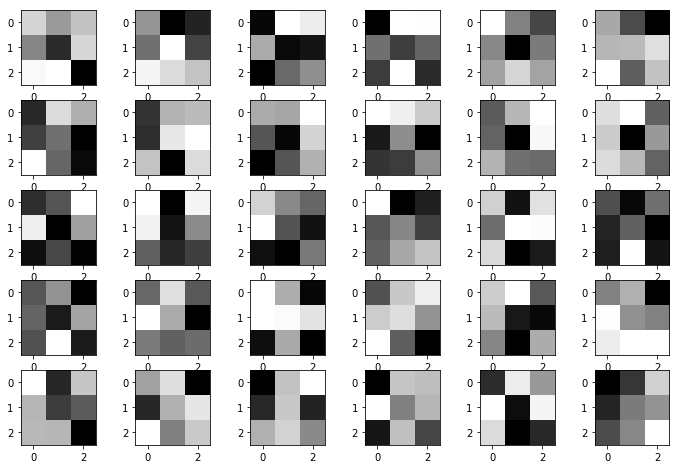

In [35]:
col_size = 6
row_size = 5
filter_index = 0
fig, ax = plt.subplots(row_size, col_size, figsize=(12,8))
for row in range(0,row_size): 
      for col in range(0,col_size):
        ax[row][col].imshow(weight_conv2d_1[:,:,filter_index],cmap="gray")
        filter_index += 1